In [1]:
# Libraries import
from datetime import datetime
from plotly.offline import init_notebook_mode
from googletrans import Translator

import plotly.graph_objs as go
import plotly.express as px
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sn

import requests
import json

In [2]:
# Data import - 'Datos abiertos COVID-19 (Colombia)'
data = pd.DataFrame.from_dict(requests.get('https://www.datos.gov.co/resource/gt2j-8ykr.json?$limit=9999999999999').json())
#data

In [3]:
# Data import - 'Colombia GeoJson'
geojson = requests.get('https://gist.githubusercontent.com/john-guerra/43c7656821069d00dcbc/raw/be6a6e239cd5b5b803c6e7c2ec405b793a9064dd/Colombia.geo.json').json()
#geojson

In [4]:
# Data cleaning and adjusting
translator = Translator()

translations = {}
counties = {}

data.columns = ['Id de caso', 'Fecha de notificación', 'Código DIVIPOLA', 'Ciudad de ubicación', 'Departamento', 'Estado', 'Edad', 'Sexo', 'Tipo', 'Severidad','País de procedencia', 'Fecha de inicio de síntomas', 'Fecha de diagnóstico', 'Fecha de recuperación', 'Fecha de reporte web', 'Tipo de recuperación', 'Código departamento', 'Código país', 'Pertenecia Étnica', 'Fecha de defunción', 'Nombre Grupo Étnico']

for element in data['País de procedencia'].unique():
    translations[element] = translator.translate(" ".join(element.split(" ")[:2])).text if type(element) !=  float else 'Colombia'

data['País de procedencia'].replace(translations, inplace=True)

for column in ['Edad', 'Código departamento']:
    data[column] = data[column].apply(lambda x: int(x))
    
data['Clasificación de edad'] = pd.cut(x=data['Edad'], bins=[-np.inf,10,20,30,40,50,60,70,80,90,np.inf], include_lowest=True, labels=['0 - 10', '10 - 20', '20 - 30', '30 - 40', '40 - 50', '50 - 60', '60 - 70', '70 - 80', '80 - 90', '90 - 100+'])

for column in ['Ciudad de ubicación', 'Estado', 'Sexo', 'Tipo', 'Severidad', 'País de procedencia']:
    data[column] = data[column].str.capitalize()
    
for column in ['Fecha de notificación', 'Fecha de inicio de síntomas', 'Fecha de defunción', 'Fecha de diagnóstico', 'Fecha de recuperación', 'Fecha de reporte web']:
    data[column] = data[column].str.slice(0,10).replace(r'(\d+)-(\d+)-(\d+)', r'\1-\2-\3', regex=True).apply(lambda x: pd.to_datetime(x, dayfirst=True, errors='ignore'))

for element in geojson['features']:
    counties[int(element['properties']['DPTO'])] = element['properties']["NOMBRE_DPT"]

data = data[['Id de caso', 'Fecha de reporte web', 'Fecha de diagnóstico', 'Fecha de notificación', 'Fecha de inicio de síntomas', 'Fecha de recuperación', 'Fecha de defunción', 'Ciudad de ubicación', 'Departamento', 'Severidad', 'Estado', 'Edad', 'Clasificación de edad', 'Sexo', 'Pertenecia Étnica', 'Nombre Grupo Étnico', 'Tipo', 'Tipo de recuperación', 'País de procedencia', 'Código departamento', 'Código país', 'Código DIVIPOLA']]
data = data.set_index('Id de caso')

In [5]:
# Testing


In [6]:
# Data storage
date = data['Fecha de reporte web'].iloc[-1].strftime('%Y-%m-%d')
data.to_csv(f'./Datasets/COVID-19 Status (Colombia) [{date}].csv', index = True)

In [7]:
# Helper functions
def numbers(div):
    for i in range(0, len(ax.patches)//div, 1):
        height = 0
        for j in range(0, div, 1):
            height += ax.patches[j*(len(ax.patches)//div)+i].get_height()
        ax.text(ax.patches[i].get_x()+(ax.patches[i].get_width()/10),height+(height/100)+10, int(height), fontsize=7, color='dimgrey', rotation=90)

def numbers_H(div):
    for i in range(0, len(ax.patches)//div, 1):
        width = 0
        for j in range(0, div, 1):
            width += ax.patches[j*(len(ax.patches)//div)+i].get_width()
        ax.text(width+(width/100)+10,ax.patches[i].get_y()+(ax.patches[i].get_height()/10), int(width), fontsize=7, color='dimgrey', rotation=0)

In [8]:
# In-line plots libraries import
%matplotlib inline
init_notebook_mode(connected = True)

# COVID-19 Status (Colombia)

#### Fuente: <a href='https://datos.gov.co'>Datos Abiertos - Colombia</a>

### - Panorama nacional COVID-19 (Colombia)

In [9]:
local_map = go.Figure(go.Choropleth(
    z=data['Código departamento'].value_counts().sort_index().tolist(),
    locations=list(counties.values()),
    featureidkey='properties.NOMBRE_DPT',
    geojson=geojson,
    colorscale='blues',
    colorbar_title="Casos positivos COVID-19",
    autocolorscale = False,
    reversescale = True,
    marker_line_color='darkgray',
    marker_line_width=0.5,
))

local_map.update_geos(showcountries=False, showcoastlines=False, showland=False, fitbounds='locations')

local_map.update_layout(
    margin={"r":0,"t":0,"l":0,"b":0},
    geo = dict(
        showframe = False,
        showcoastlines = False,
        projection_type = 'equirectangular'
    ),
    annotations = [
        dict(
            x=0.55,
            y=0.15,
            xref='paper',
            yref='paper',
            text= f'Colombia: {len(data.index):,} casos confirmados de COVID-19',
            showarrow = False
        ),
        dict(
            x=0.55,
            y=0.1,
            xref='paper',
            yref='paper',
            text= f'Fecha: {date}',
            showarrow = False
        ),
        dict(
            x=0.55,
            y=0.05,
            xref='paper',
            yref='paper',
            text='Fuente: <a href="https://datos.gov.co">Datos Abiertos - Colombia</a>',
            showarrow = False
        ),
    ]
)

local_map.show()

### - Dataset COVID-19 (Colombia)

In [10]:
data

Fecha de reporte web Fecha de diagnóstico Fecha de notificación  \
Id de caso                                                                   
1                    2020-03-06           2020-03-06            2020-03-02   
2                    2020-03-09           2020-03-09            2020-03-06   
3                    2020-03-09           2020-03-09            2020-03-07   
4                    2020-03-11           2020-03-11            2020-03-09   
5                    2020-03-11           2020-03-11            2020-03-09   
...                         ...                  ...                   ...   
468368               2020-08-16           2020-08-14            2020-08-03   
468369               2020-08-16           2020-08-14            2020-08-03   
468370               2020-08-16           2020-08-14            2020-08-03   
468371               2020-08-16           2020-08-14            2020-08-03   
468372               2020-08-16           2020-08-14            2020-08-03   

           Fecha de inicio de síntomas Fecha de recuperación  \
Id de caso                                                     
1                  2020-02-27 00:00:00            2020-03-13   
2                  2020-03-04 00:00:00            2020-03-19   
3                  2020-02-29 00:00:00            2020-03-15   
4                  2020-03-06 00:00:00            2020-03-26   
5                  2020-03-08 00:00:00            2020-03-23   
...                                ...                   ...   
468368             2020-07-27 00:00:00                   NaT   
468369             2020-07-27 00:00:00                   NaT   
468370             2020-07-27 00:00:00                   NaT   
468371             2020-07-27 00:00:00                   NaT   
468372             2020-07-27 00:00:00                   NaT   

           Fecha de defunción  Ciudad de ubicación     Departamento Severidad  \
Id de caso                                                                      
1                         NaT          Bogotá d.c.      Bogotá D.C.      Leve   
2                         NaT  Guadalajara de buga  Valle del Cauca      Leve   
3                         NaT             Medellín        Antioquia      Leve   
4                         NaT             Medellín        Antioquia      Leve   
5                         NaT             Medellín        Antioquia      Leve   
...                       ...                  ...              ...       ...   
468368                    NaT            Florencia          Caquetá      Leve   
468369                    NaT            Florencia          Caquetá      Leve   
468370                    NaT            Florencia          Caquetá      Leve   
468371                    NaT            Florencia          Caquetá      Leve   
468372                    NaT            Florencia          Caquetá      Leve   

                Estado  ...  Clasificación de edad Sexo Pertenecia Étnica  \
Id de caso              ...                                                 
1           Recuperado  ...                10 - 20    F              Otro   
2           Recuperado  ...                30 - 40    M              Otro   
3           Recuperado  ...                40 - 50    F              Otro   
4           Recuperado  ...                50 - 60    M              Otro   
5           Recuperado  ...                20 - 30    M              Otro   
...                ...  ...                    ...  ...               ...   
468368            Casa  ...                30 - 40    F               NaN   
468369            Casa  ...                30 - 40    M               NaN   
468370            Casa  ...                20 - 30    F               NaN   
468371            Casa  ...                 0 - 10    M               NaN   
468372            Casa  ...                20 - 30    F               NaN   

           Nombre Grupo Étnico         Tipo Tipo de recuperación  \
Id de caso                             

### - Casos confirmados VS Departamento (Estado)

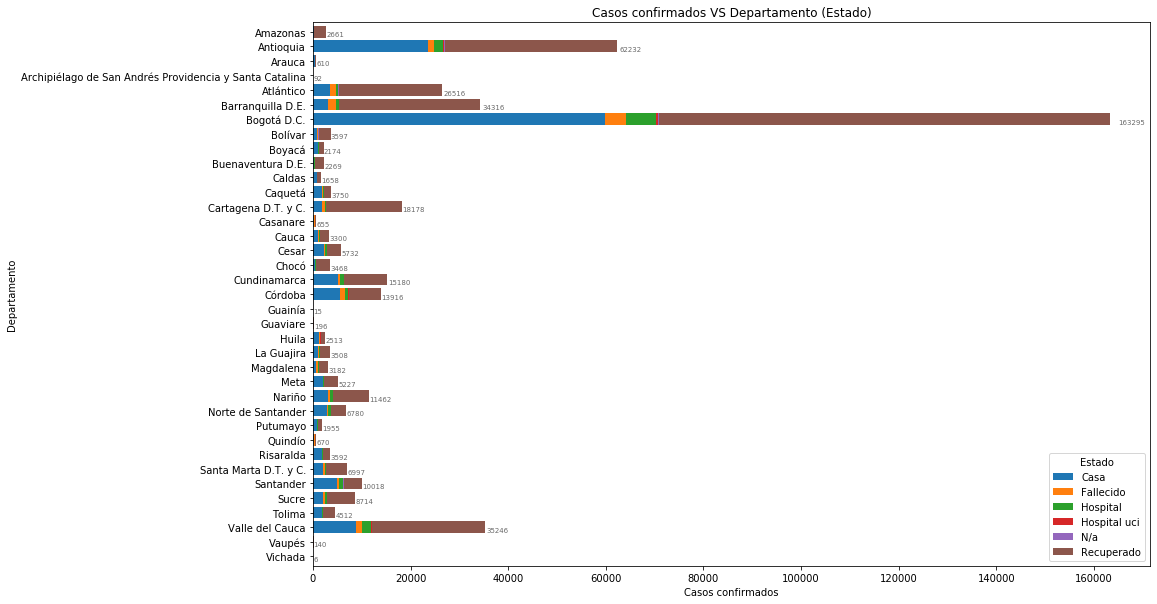

In [11]:
ax = data.groupby(['Departamento', 'Estado']).size().unstack().fillna(0).sort_index(ascending=False).plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados VS Departamento (Estado)'))
ax.set_xlabel('Casos confirmados')
div = len(data['Estado'].unique())
numbers_H(div)

In [12]:
data.groupby(['Departamento', 'Estado']).size().unstack().fillna(0)

Estado                                                 Casa  Fallecido  \
Departamento                                                             
Amazonas                                              123.0      107.0   
Antioquia                                           23597.0     1161.0   
Arauca                                                332.0       10.0   
Archipiélago de San Andrés Providencia y Santa ...     43.0        0.0   
Atlántico                                            3531.0     1189.0   
Barranquilla D.E.                                    3116.0     1576.0   
Bogotá D.C.                                         59855.0     4358.0   
Bolívar                                               848.0      152.0   
Boyacá                                               1046.0       54.0   
Buenaventura D.E.                                     121.0      155.0   
Caldas                                                753.0       24.0   
Caquetá                                              1910.0      103.0   
Cartagena D.T. y C.                                  1896.0      492.0   
Casanare                                              308.0       13.0   
Cauca                                                1044.0      114.0   
Cesar                                                2273.0      124.0   
Chocó                                                 344.0      123.0   
Cundinamarca                                         5177.0      430.0   
Córdoba                                              5634.0      949.0   
Guainía                                                 1.0        1.0   
Guaviare                                               90.0        0.0   
Huila                                                1306.0       67.0   
La Guajira                                           1001.0      170.0   
Magdalena                                             725.0      258.0   
Meta                                                 1986.0       92.0   
Nariño                                               3079.0      409.0   
Norte de Santander                                   2791.0      386.0   
Putumayo                                              835.0       89.0   
Quindío                                               307.0       18.0   
Risaralda                                            1887.0       62.0   
Santa Marta D.T. y C.                                2145.0      247.0   
Santander                                            5002.0      397.0   
Sucre                                                2027.0      419.0   
Tolima                                               1813.0      101.0   
Valle del Cauca                                      8880.0     1246.0   
Vaupés                                                 79.0        1.0   
Vichada                                                 1.0        0.0   

Estado                                              Hospital  Hospital uci  \
Departamento                                                                 
Amazonas                                                 8.0           2.0   
Antioquia                                             1968.0         169.0   
Arauca                                                  21.0           2.0   
Archipiélago de San Andrés Providencia y Santa ...       7.0           1.0   
Atlántico                                              410.0          64.0   
Barranquilla D.E.                                      552.0          42.0   
Bogotá D.C.                                           5959.0         555.0   
Bolívar                                                124.0          12.0   
Boyacá                                                 110.0           8.0   
Buenaventura D.E.                                       93.0          16.0   
Caldas                                                  63.0           7.0   
Caquetá                                                202.0           8.0   
Cartagena D.T. y C.  

### - Casos confirmados VS Departamento (Sexo)

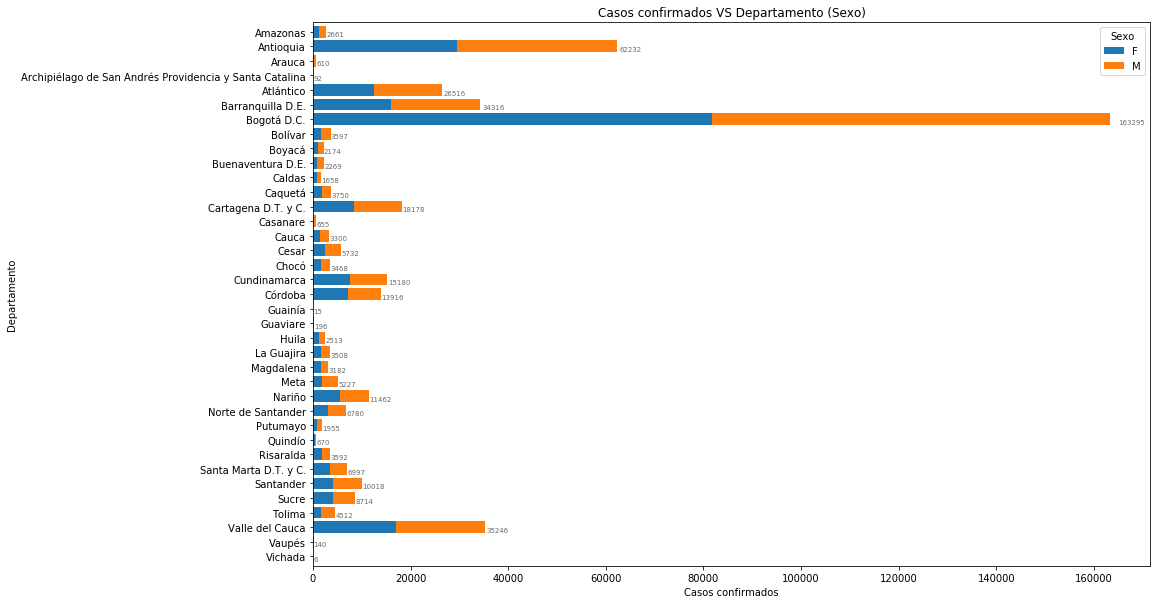

In [13]:
ax = data.groupby(['Departamento', 'Sexo']).size().unstack().fillna(0).sort_index(ascending=False).plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados VS Departamento (Sexo)'))
ax.set_xlabel('Casos confirmados')
div = len(data['Sexo'].unique())
numbers_H(div)

In [14]:
data.groupby(['Departamento', 'Sexo']).size().unstack().fillna(0)

Sexo                                                    F      M
Departamento                                                    
Amazonas                                             1149   1512
Antioquia                                           29534  32698
Arauca                                                176    434
Archipiélago de San Andrés Providencia y Santa ...     42     50
Atlántico                                           12568  13948
Barranquilla D.E.                                   16055  18261
Bogotá D.C.                                         81824  81471
Bolívar                                              1619   1978
Boyacá                                               1025   1149
Buenaventura D.E.                                     839   1430
Caldas                                                814    844
Caquetá                                              1826   1924
Cartagena D.T. y C.                                  8310   9868
Casanare                                              267    388
Cauca                                                1501   1799
Cesar                                                2559   3173
Chocó                                                1619   1849
Cundinamarca                                         7643   7537
Córdoba                                              7103   6813
Guainía                                                 6      9
Guaviare                                               25    171
Huila                                                1248   1265
La Guajira                                           1743   1765
Magdalena                                            1590   1592
Meta                                                 1770   3457
Nariño                                               5457   6005
Norte de Santander                                   2989   3791
Putumayo                                              905   1050
Quindío                                               330    340
Risaralda                                            1803   1789
Santa Marta D.T. y C.                                3475   3522
Santander                                            4174   5844
Sucre                                                4085   4629
Tolima                                               1666   2846
Valle del Cauca                                     16929  18317
Vaupés                                                 67     73
Vichada                                                 2      4

### - Casos confirmados VS Departamento (Clasificación de edad)

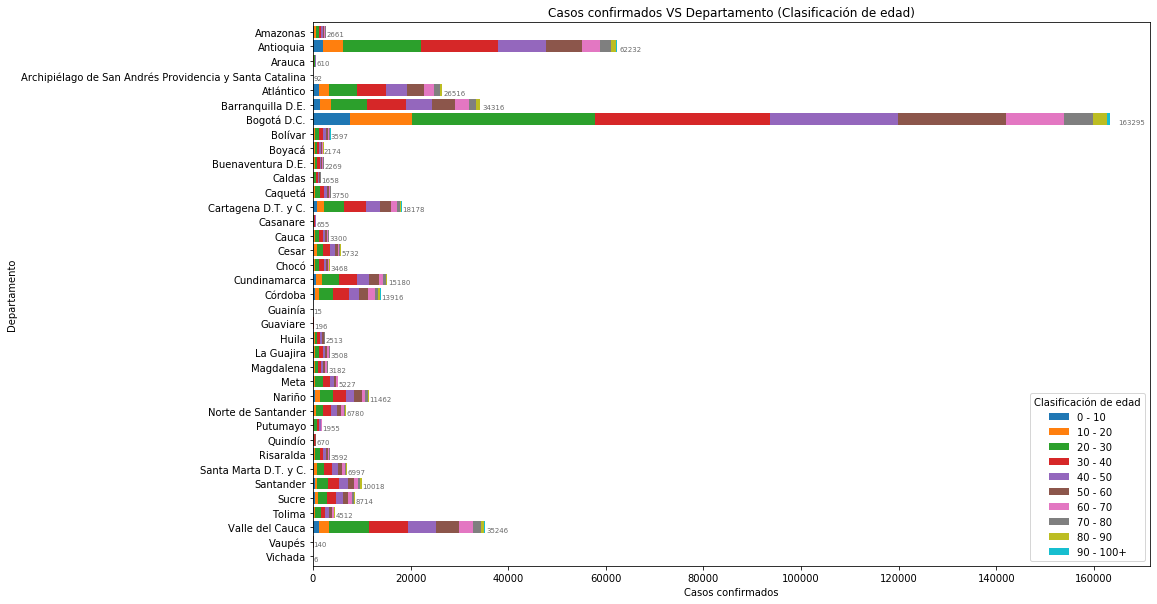

In [15]:
ax = data.groupby(['Departamento', 'Clasificación de edad']).size().unstack().fillna(0).sort_index(ascending=False).plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados VS Departamento (Clasificación de edad)'))
ax.set_xlabel('Casos confirmados')
div = len(data['Clasificación de edad'].unique())
numbers_H(div)

In [16]:
data.groupby(['Departamento', 'Clasificación de edad']).size().unstack().fillna(0)

Clasificación de edad                               0 - 10  10 - 20  20 - 30  \
Departamento                                                                   
Amazonas                                               145      467      540   
Antioquia                                             2071     4126    16037   
Arauca                                                  22      109      188   
Archipiélago de San Andrés Providencia y Santa ...       2       10       20   
Atlántico                                             1202     2162     5581   
Barranquilla D.E.                                     1356     2281     7421   
Bogotá D.C.                                           7580    12678    37464   
Bolívar                                                185      336      802   
Boyacá                                                 113      209      444   
Buenaventura D.E.                                       52      294      520   
Caldas                                                  63      124      372   
Caquetá                                                109      253     1006   
Cartagena D.T. y C.                                    862     1362     4124   
Casanare                                                28       33      195   
Cauca                                                  129      249      776   
Cesar                                                  309      474     1364   
Chocó                                                  148      307      816   
Cundinamarca                                           680     1124     3523   
Córdoba                                                428      890     2818   
Guainía                                                  0        2        4   
Guaviare                                                 3       38       66   
Huila                                                  115      215      549   
La Guajira                                             202      318      699   
Magdalena                                              178      236      585   
Meta                                                   124      382     1524   
Nariño                                                 493      927     2681   
Norte de Santander                                     194      337     1491   
Putumayo                                                54      171      546   
Quindío                                                 25       34      167   
Risaralda                                              182      303      911   
Santa Marta D.T. y C.                                  287      513     1486   
Santander                                              331      569     2228   
Sucre                                                  350      767     1787   
Tolima                                                 197      284     1126   
Valle del Cauca                                       1150     2235     8156   
Vaupés                                                   8       13       44   
Vichada                                                  0        4        1   

Clasificación de edad                               30 - 40  40 - 50  50 - 60  \
Departamento                                                                    
Amazonas                                                512      360      296   
Antioquia                                             15623     9782     7546   
Arauca                                                  158       66       39   
Archipiélago de San Andrés Providencia y Santa ...       25       16       12   
Atlántico                                              6029     4244     3523   
Barranquilla D.E.                                      8047     5379     4628   
Bogotá D.C.                                           35989    26091    22135   
Bolívar                                                 820      515      348   
Boyacá                                                  453      355 

### - Mapa de influencia COVID-19 (Colombia)

In [17]:
global_map = go.Figure(data = go.Choropleth(
    z = data['País de procedencia'].value_counts().sort_index().tolist(),
    locations = sorted(data['País de procedencia'].unique().tolist()),
    locationmode = 'country names',
    colorscale = 'greens',
    colorbar_title = "Casos positivos COVID-19",
    autocolorscale = False,
    reversescale = True,
    marker_line_color='darkgray',
    marker_line_width=0.5,
))

global_map.update_layout(
    margin={"r":0,"t":0,"l":0,"b":0},
    geo = dict(
        showframe = False,
        showcoastlines = False,
        projection_type = 'equirectangular'
    ),
    annotations = [
        dict(
            x=0.55,
            y=0.15,
            xref='paper',
            yref='paper',
            text= f'Colombia: {len(data.index):,} casos confirmados de COVID-19',
            showarrow = False
        ),
        dict(
            x=0.55,
            y=0.1,
            xref='paper',
            yref='paper',
            text= f'Fecha: {date}',
            showarrow = False
        ),
        dict(
            x=0.55,
            y=0.05,
            xref='paper',
            yref='paper',
            text='Fuente: <a href="https://datos.gov.co">Datos Abiertos - Colombia</a>',
            showarrow = False
        ),
    ]
)

global_map.show()

### - Casos confirmados acumulado VS Fecha de diagnóstico (Estado)

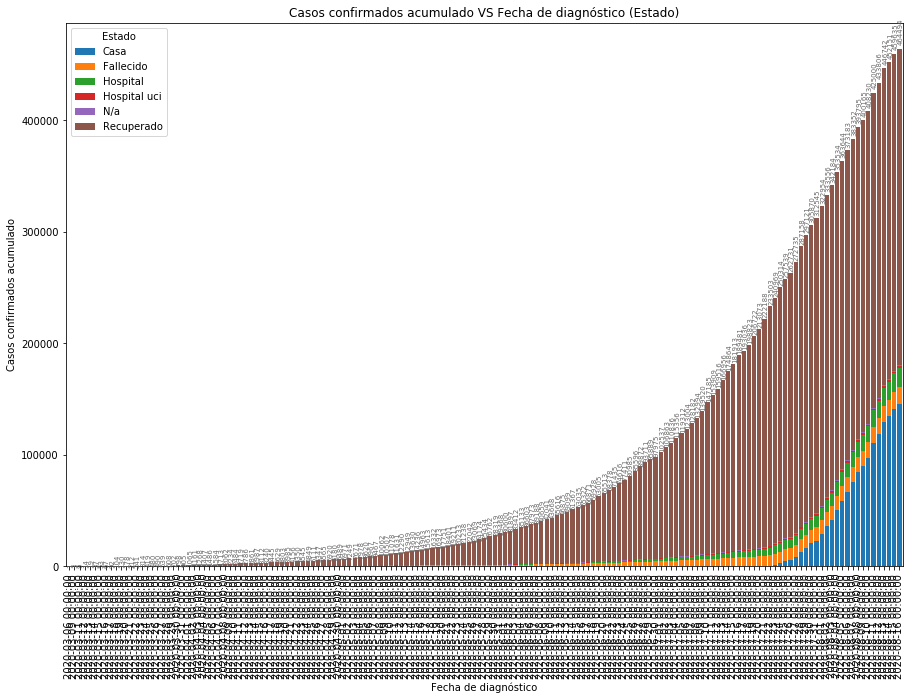

In [18]:
ax = data.groupby(['Fecha de diagnóstico', 'Estado']).size().unstack().fillna(0).cumsum().plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados acumulado VS Fecha de diagnóstico (Estado)'))
ax.set_ylabel('Casos confirmados acumulado')
div = len(data['Estado'].unique())
numbers(div)

In [19]:
data.groupby(['Fecha de diagnóstico', 'Estado']).size().unstack().fillna(0).cumsum().tail(60)

Estado                    Casa  Fallecido  Hospital  Hospital uci    N/a  \
Fecha de diagnóstico                                                       
2020-06-18                 8.0     2687.0     827.0         217.0  193.0   
2020-06-19                 8.0     2820.0     896.0         230.0  207.0   
2020-06-20                 8.0     2949.0     981.0         240.0  212.0   
2020-06-21                10.0     3097.0    1056.0         253.0  225.0   
2020-06-22                10.0     3190.0    1123.0         261.0  235.0   
2020-06-23                10.0     3332.0    1220.0         272.0  249.0   
2020-06-24                12.0     3472.0    1299.0         285.0  257.0   
2020-06-25                13.0     3632.0    1431.0         304.0  270.0   
2020-06-26                13.0     3815.0    1553.0         322.0  285.0   
2020-06-27                14.0     3990.0    1722.0         334.0  296.0   
2020-06-28                14.0     4152.0    1848.0         343.0  304.0   
2020-06-29                15.0     4259.0    1913.0         354.0  309.0   
2020-06-30                15.0     4318.0    1977.0         360.0  314.0   
2020-07-01                15.0     4529.0    2139.0         381.0  326.0   
2020-07-02                17.0     4733.0    2285.0         408.0  338.0   
2020-07-03                18.0     4928.0    2420.0         424.0  347.0   
2020-07-04                18.0     5119.0    2616.0         448.0  365.0   
2020-07-05                18.0     5263.0    2725.0         466.0  379.0   
2020-07-06                19.0     5393.0    2817.0         479.0  391.0   
2020-07-07                19.0     5601.0    3042.0         509.0  409.0   
2020-07-08                19.0     5838.0    3211.0         537.0  418.0   
2020-07-09                19.0     6129.0    3481.0         578.0  427.0   
2020-07-10                21.0     6344.0    3699.0         604.0  443.0   
2020-07-11                22.0     6599.0    3923.0         624.0  469.0   
2020-07-12                22.0     6807.0    4096.0         652.0  482.0   
2020-07-13                22.0     7067.0    4382.0         694.0  503.0   
2020-07-14                22.0     7347.0    4637.0         721.0  524.0   
2020-07-15                25.0     7628.0    4889.0         752.0  533.0   
2020-07-16                27.0     7901.0    5183.0         782.0  551.0   
2020-07-17                28.0     8064.0    5311.0         795.0  559.0   
2020-07-18                29.0     8292.0    5514.0         825.0  580.0   
2020-07-19                29.0     8558.0    5820.0         855.0  596.0   
2020-07-20                29.0     8816.0    6167.0         893.0  605.0   
2020-07-21                41.0     9145.0    6495.0         945.0  616.0   
2020-07-22               258.0     9562.0    6953.0        1000.0  639.0   
2020-07-23              1566.0     9907.0    7346.0        1039.0  666.0   
2020-07-24              2997.0    10179.0    7690.0        1075.0  685.0   
2020-07-25              4764.0    10458.0    8042.0        1116.0  695.0   
2020-07-26              5709.0    10678.0    8255.0        1145.0  702.0   
2020-07-27              8333.0    10957.0    8578.0        1191.0  720.0   
2020-07-28             13058.0    11444.0    9175.0        1258.0  750.0   
2020-07-29             16693.0    11695.0    9542.0        1304.0  770.0   
2020-07-30             20562.0    11945.0    9871.0        1353.0  782.0   
2020-07-31             23121.0    12141.0   10142.0        1377.0  797.0   
2020-08-01             29004.0    12432.0   10625.0        1407.0  815.0   
2020-08-02             35792.0    12732.0   11118.0        1430.0  828.0   
2020-08-03             41205.0    12990.0   11566.0        1455.0  841.0   
2020-08-04             50310.0    13208.0   11963.0        1486.0  853.0   
2020-08-05             58735.0    13407.0   12391.0        1502.0  865.0   
2020-08-06             66658.0    13608.0   12752.0        1532.0  880.0   
2020-08-07             75233.0    13804.0   1313

### - Casos confirmados VS Fecha de diagnóstico (Estado)

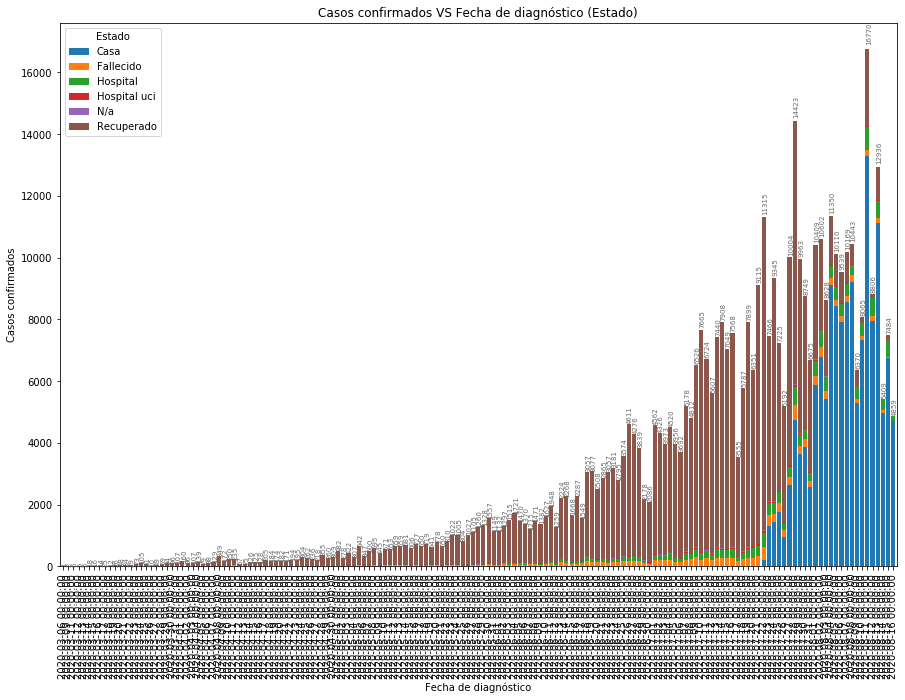

In [20]:
ax = data.groupby(['Fecha de diagnóstico', 'Estado']).size().unstack().fillna(0).plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados VS Fecha de diagnóstico (Estado)'))
ax.set_ylabel('Casos confirmados')
div = len(data['Estado'].unique())
numbers(div)

In [21]:
data.groupby(['Fecha de diagnóstico', 'Estado']).size().unstack().fillna(0).tail(60)

Estado                   Casa  Fallecido  Hospital  Hospital uci   N/a  \
Fecha de diagnóstico                                                     
2020-06-18                0.0      177.0      92.0          16.0   8.0   
2020-06-19                0.0      133.0      69.0          13.0  14.0   
2020-06-20                0.0      129.0      85.0          10.0   5.0   
2020-06-21                2.0      148.0      75.0          13.0  13.0   
2020-06-22                0.0       93.0      67.0           8.0  10.0   
2020-06-23                0.0      142.0      97.0          11.0  14.0   
2020-06-24                2.0      140.0      79.0          13.0   8.0   
2020-06-25                1.0      160.0     132.0          19.0  13.0   
2020-06-26                0.0      183.0     122.0          18.0  15.0   
2020-06-27                1.0      175.0     169.0          12.0  11.0   
2020-06-28                0.0      162.0     126.0           9.0   8.0   
2020-06-29                1.0      107.0      65.0          11.0   5.0   
2020-06-30                0.0       59.0      64.0           6.0   5.0   
2020-07-01                0.0      211.0     162.0          21.0  12.0   
2020-07-02                2.0      204.0     146.0          27.0  12.0   
2020-07-03                1.0      195.0     135.0          16.0   9.0   
2020-07-04                0.0      191.0     196.0          24.0  18.0   
2020-07-05                0.0      144.0     109.0          18.0  14.0   
2020-07-06                1.0      130.0      92.0          13.0  12.0   
2020-07-07                0.0      208.0     225.0          30.0  18.0   
2020-07-08                0.0      237.0     169.0          28.0   9.0   
2020-07-09                0.0      291.0     270.0          41.0   9.0   
2020-07-10                2.0      215.0     218.0          26.0  16.0   
2020-07-11                1.0      255.0     224.0          20.0  26.0   
2020-07-12                0.0      208.0     173.0          28.0  13.0   
2020-07-13                0.0      260.0     286.0          42.0  21.0   
2020-07-14                0.0      280.0     255.0          27.0  21.0   
2020-07-15                3.0      281.0     252.0          31.0   9.0   
2020-07-16                2.0      273.0     294.0          30.0  18.0   
2020-07-17                1.0      163.0     128.0          13.0   8.0   
2020-07-18                1.0      228.0     203.0          30.0  21.0   
2020-07-19                0.0      266.0     306.0          30.0  16.0   
2020-07-20                0.0      258.0     347.0          38.0   9.0   
2020-07-21               12.0      329.0     328.0          52.0  11.0   
2020-07-22              217.0      417.0     458.0          55.0  23.0   
2020-07-23             1308.0      345.0     393.0          39.0  27.0   
2020-07-24             1431.0      272.0     344.0          36.0  19.0   
2020-07-25             1767.0      279.0     352.0          41.0  10.0   
2020-07-26              945.0      220.0     213.0          29.0   7.0   
2020-07-27             2624.0      279.0     323.0          46.0  18.0   
2020-07-28             4725.0      487.0     597.0          67.0  30.0   
2020-07-29             3635.0      251.0     367.0          46.0  20.0   
2020-07-30             3869.0      250.0     329.0          49.0  12.0   
2020-07-31             2559.0      196.0     271.0          24.0  15.0   
2020-08-01             5883.0      291.0     483.0          30.0  18.0   
2020-08-02             6788.0      300.0     493.0          23.0  13.0   
2020-08-03             5413.0      258.0     448.0          25.0  13.0   
2020-08-04             9105.0      218.0     397.0          31.0  12.0   
2020-08-05             8425.0      199.0     428.0          16.0  12.0   
2020-08-06             7923.0      201.0     361.0          30.0  15.0   
2020-08-07             8575.0      196.0     381.0          24.0  12.0   
2020-08-08             9219.0      206.0     345.0          20.0   8.0   
2020

### - Casos confirmados VS Clasificación de edad (Estado)

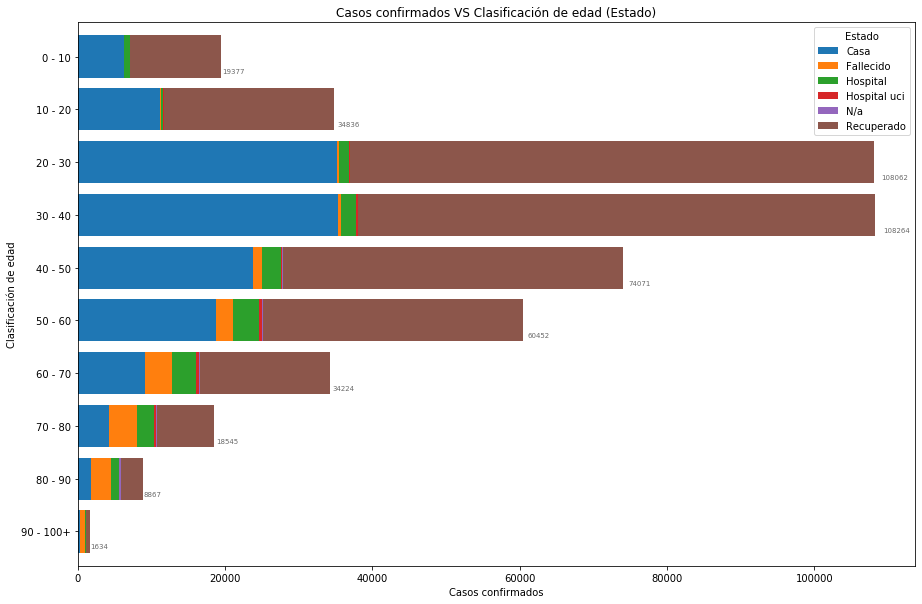

In [22]:
ax = data.groupby(['Clasificación de edad', 'Estado']).size().unstack().fillna(0).sort_index(ascending=False).plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados VS Clasificación de edad (Estado)'))
ax.set_xlabel('Casos confirmados')
div = len(data['Estado'].unique())
numbers_H(div)

In [23]:
data.groupby(['Clasificación de edad', 'Estado']).size().unstack().fillna(0)

Estado                  Casa  Fallecido  Hospital  Hospital uci  N/a  \
Clasificación de edad                                                  
0 - 10                  6254         28       725            57   26   
10 - 20                11200         24       373            25   18   
20 - 30                35235        200      1385            69   42   
30 - 40                35263        502      2057           150   36   
40 - 50                23833       1146      2539           239   74   
50 - 60                18743       2274      3529           415  118   
60 - 70                 9095       3659      3258           377  199   
70 - 80                 4258       3825      2215           245  221   
80 - 90                 1726       2800      1043            66  186   
90 - 100+                299        639       153             6   47   

Estado                 Recuperado  
Clasificación de edad              
0 - 10                      12287  
10 - 20                     23196  
20 - 30                     71131  
30 - 40                     70256  
40 - 50                     46240  
50 - 60                     35373  
60 - 70                     17636  
70 - 80                      7781  
80 - 90                      3046  
90 - 100+                     490

### - Casos confirmados acumulado VS Fecha de diagnóstico (Sexo)

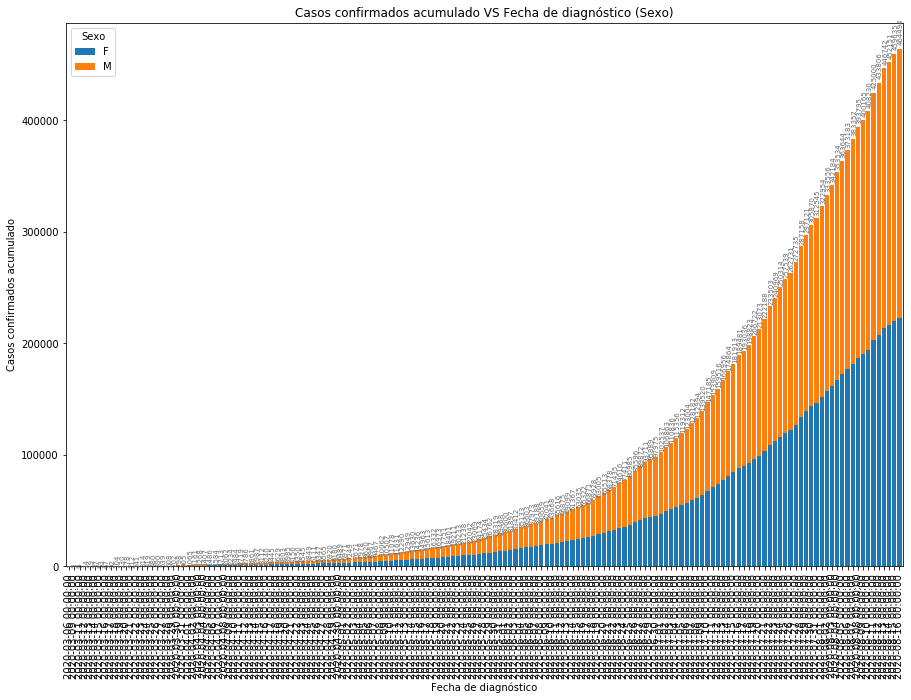

In [24]:
ax = data.groupby(['Fecha de diagnóstico', 'Sexo']).size().unstack().fillna(0).cumsum().plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados acumulado VS Fecha de diagnóstico (Sexo)'))
ax.set_ylabel('Casos confirmados acumulado')
div = len(data['Sexo'].unique())
numbers(div)

In [25]:
data.groupby(['Fecha de diagnóstico', 'Sexo']).size().unstack().fillna(0).cumsum().tail(60)

Sexo                         F         M
Fecha de diagnóstico                    
2020-06-18             27258.0   32670.0
2020-06-19             28824.0   34181.0
2020-06-20             29995.0   35518.0
2020-06-21             31244.0   37134.0
2020-06-22             32626.0   38809.0
2020-06-23             34197.0   40419.0
2020-06-24             35541.0   41870.0
2020-06-25             37111.0   43874.0
2020-06-26             39305.0   46291.0
2020-06-27             41301.0   48571.0
2020-06-28             43138.0   50573.0
2020-06-29             44132.0   51757.0
2020-06-30             45104.0   52871.0
2020-07-01             47176.0   55361.0
2020-07-02             49197.0   57666.0
2020-07-03             51053.0   59783.0
2020-07-04             53076.0   62280.0
2020-07-05             54909.0   64403.0
2020-07-06             56658.0   66346.0
2020-07-07             59061.0   69121.0
2020-07-08             61369.0   71625.0
2020-07-09             64330.0   75190.0
2020-07-10             67830.0   79355.0
2020-07-11             71019.0   82890.0
2020-07-12             73687.0   85829.0
2020-07-13             77254.0   89702.0
2020-07-14             80856.0   94008.0
2020-07-15             84192.0   97721.0
2020-07-16             87908.0  101573.0
2020-07-17             89657.0  103379.0
2020-07-18             92431.0  106392.0
2020-07-19             96215.0  110507.0
2020-07-20             99181.0  113892.0
2020-07-21            103446.0  118742.0
2020-07-22            108547.0  124956.0
2020-07-23            112073.0  128896.0
2020-07-24            116389.0  133925.0
2020-07-25            120044.0  137495.0
2020-07-26            122423.0  140308.0
2020-07-27            127211.0  145524.0
2020-07-28            134236.0  152922.0
2020-07-29            139172.0  157949.0
2020-07-30            143422.0  162448.0
2020-07-31            146783.0  165762.0
2020-08-01            151817.0  171137.0
2020-08-02            157237.0  176319.0
2020-08-03            161412.0  180772.0
2020-08-04            167099.0  186435.0
2020-08-05            172187.0  191457.0
2020-08-06            176914.0  196269.0
2020-08-07            181887.0  201465.0
2020-08-08            186960.0  206835.0
2020-08-09            190245.0  209920.0
2020-08-10            194300.0  213930.0
2020-08-11            202987.0  222013.0
2020-08-12            207352.0  226454.0
2020-08-13            213842.0  232900.0
2020-08-14            216565.0  235586.0
2020-08-15            220411.0  239224.0
2020-08-16            222923.0  241571.0

### - Casos confirmados VS Fecha de diagnóstico (Sexo)

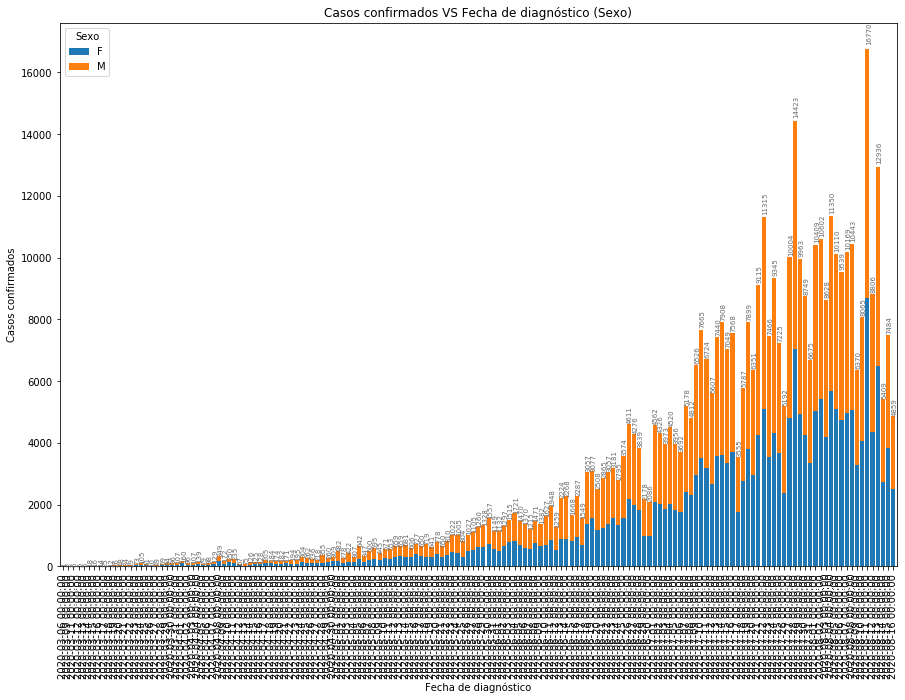

In [26]:
ax = data.groupby(['Fecha de diagnóstico', 'Sexo']).size().unstack().fillna(0).plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados VS Fecha de diagnóstico (Sexo)'))
ax.set_ylabel('Casos confirmados')
div = len(data['Sexo'].unique())
numbers(div)

In [27]:
data.groupby(['Fecha de diagnóstico', 'Sexo']).size().unstack().fillna(0).tail(60)

Sexo                       F       M
Fecha de diagnóstico                
2020-06-18            1379.0  1678.0
2020-06-19            1566.0  1511.0
2020-06-20            1171.0  1337.0
2020-06-21            1249.0  1616.0
2020-06-22            1382.0  1675.0
2020-06-23            1571.0  1610.0
2020-06-24            1344.0  1451.0
2020-06-25            1570.0  2004.0
2020-06-26            2194.0  2417.0
2020-06-27            1996.0  2280.0
2020-06-28            1837.0  2002.0
2020-06-29             994.0  1184.0
2020-06-30             972.0  1114.0
2020-07-01            2072.0  2490.0
2020-07-02            2021.0  2305.0
2020-07-03            1856.0  2117.0
2020-07-04            2023.0  2497.0
2020-07-05            1833.0  2123.0
2020-07-06            1749.0  1943.0
2020-07-07            2403.0  2775.0
2020-07-08            2308.0  2504.0
2020-07-09            2961.0  3565.0
2020-07-10            3500.0  4165.0
2020-07-11            3189.0  3535.0
2020-07-12            2668.0  2939.0
2020-07-13            3567.0  3873.0
2020-07-14            3602.0  4306.0
2020-07-15            3336.0  3713.0
2020-07-16            3716.0  3852.0
2020-07-17            1749.0  1806.0
2020-07-18            2774.0  3013.0
2020-07-19            3784.0  4115.0
2020-07-20            2966.0  3385.0
2020-07-21            4265.0  4850.0
2020-07-22            5101.0  6214.0
2020-07-23            3526.0  3940.0
2020-07-24            4316.0  5029.0
2020-07-25            3655.0  3570.0
2020-07-26            2379.0  2813.0
2020-07-27            4788.0  5216.0
2020-07-28            7025.0  7398.0
2020-07-29            4936.0  5027.0
2020-07-30            4250.0  4499.0
2020-07-31            3361.0  3314.0
2020-08-01            5034.0  5375.0
2020-08-02            5420.0  5182.0
2020-08-03            4175.0  4453.0
2020-08-04            5687.0  5663.0
2020-08-05            5088.0  5022.0
2020-08-06            4727.0  4812.0
2020-08-07            4973.0  5196.0
2020-08-08            5073.0  5370.0
2020-08-09            3285.0  3085.0
2020-08-10            4055.0  4010.0
2020-08-11            8687.0  8083.0
2020-08-12            4365.0  4441.0
2020-08-13            6490.0  6446.0
2020-08-14            2723.0  2686.0
2020-08-15            3846.0  3638.0
2020-08-16            2512.0  2347.0

### - Casos confirmados VS Clasificación de edad (Sexo)

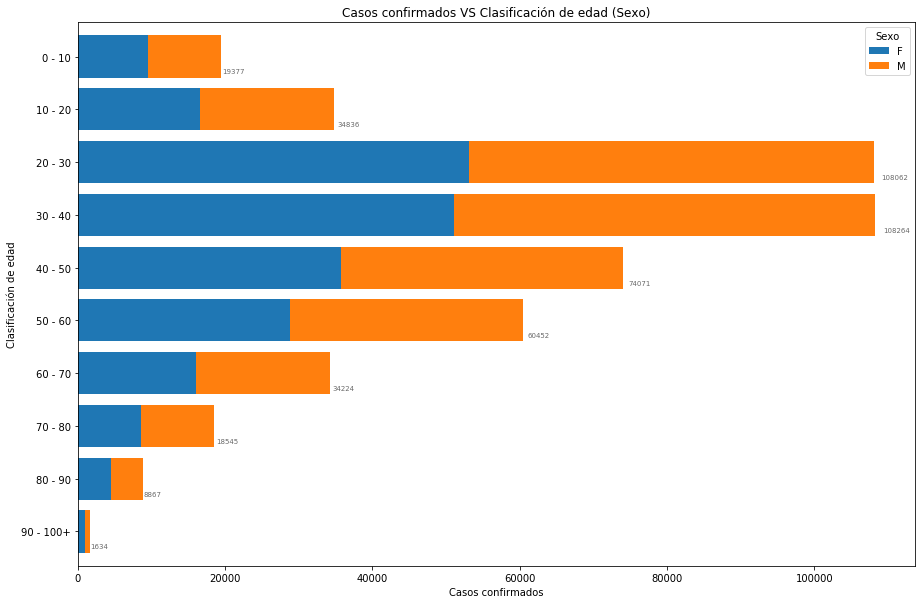

In [28]:
ax = data.groupby(['Clasificación de edad', 'Sexo']).size().unstack().fillna(0).sort_index(ascending=False).plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados VS Clasificación de edad (Sexo)'))
ax.set_xlabel('Casos confirmados')
div = len(data['Sexo'].unique())
numbers_H(div)

In [29]:
data.groupby(['Clasificación de edad', 'Sexo']).size().unstack().fillna(0)

Sexo                       F      M
Clasificación de edad              
0 - 10                  9471   9906
10 - 20                16513  18323
20 - 30                53169  54893
30 - 40                51132  57132
40 - 50                35711  38360
50 - 60                28762  31690
60 - 70                16003  18221
70 - 80                 8564   9981
80 - 90                 4478   4389
90 - 100+                934    700

### - Casos confirmados VS Estado (Sexo)

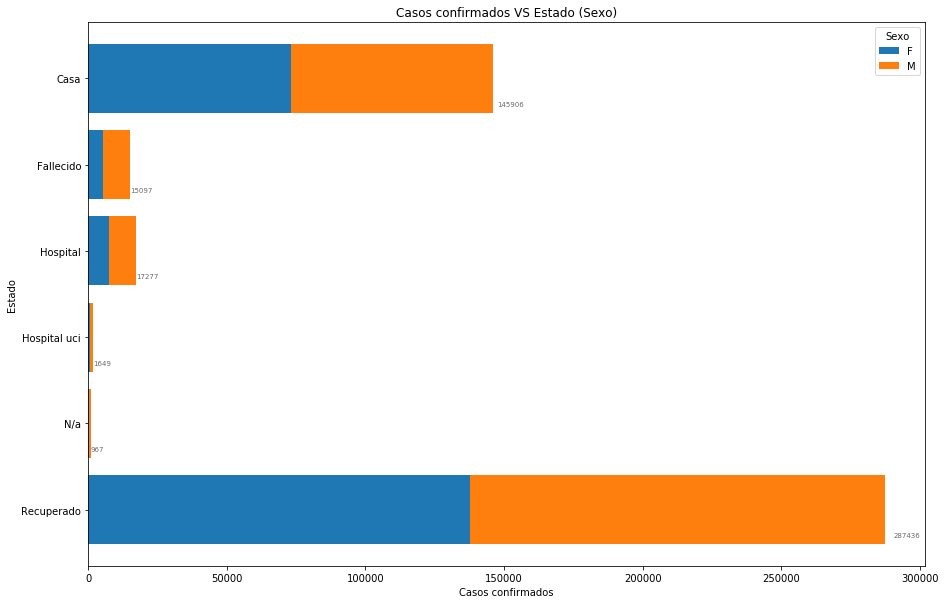

In [30]:
ax = data.groupby(['Estado', 'Sexo']).size().unstack().fillna(0).sort_index(ascending=False).plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados VS Estado (Sexo)'))
ax.set_xlabel('Casos confirmados')
div = len(data['Sexo'].unique())
numbers_H(div)

In [31]:
data.groupby(['Estado', 'Sexo']).size().unstack().fillna(0)

Sexo               F       M
Estado                      
Casa           73294   72612
Fallecido       5414    9683
Hospital        7394    9883
Hospital uci     577    1072
N/a              413     554
Recuperado    137645  149791

### - Casos confirmados VS Tipo de contagio (Sexo)

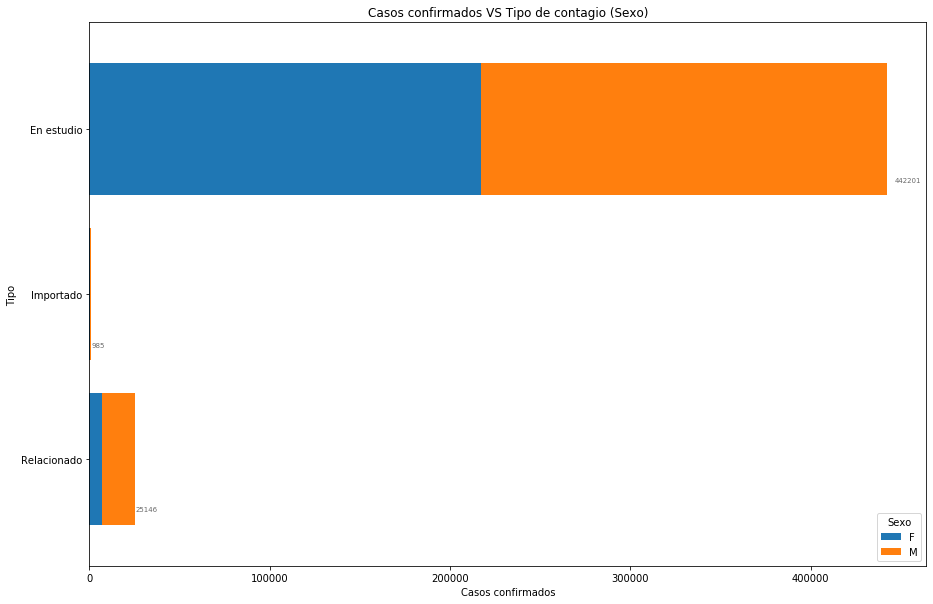

In [32]:
ax = data.groupby(['Tipo', 'Sexo']).size().unstack().fillna(0).sort_index(ascending=False).plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados VS Tipo de contagio (Sexo)'))
ax.set_xlabel('Casos confirmados')
div = len(data['Sexo'].unique())
numbers_H(div)

In [33]:
data.groupby(['Tipo', 'Sexo']).size().unstack().fillna(0)

Sexo              F       M
Tipo                       
En estudio   217212  224989
Importado       460     525
Relacionado    7065   18081

### - Casos confirmados acumulado VS Fecha de diagnóstico (Clasificación de edad)

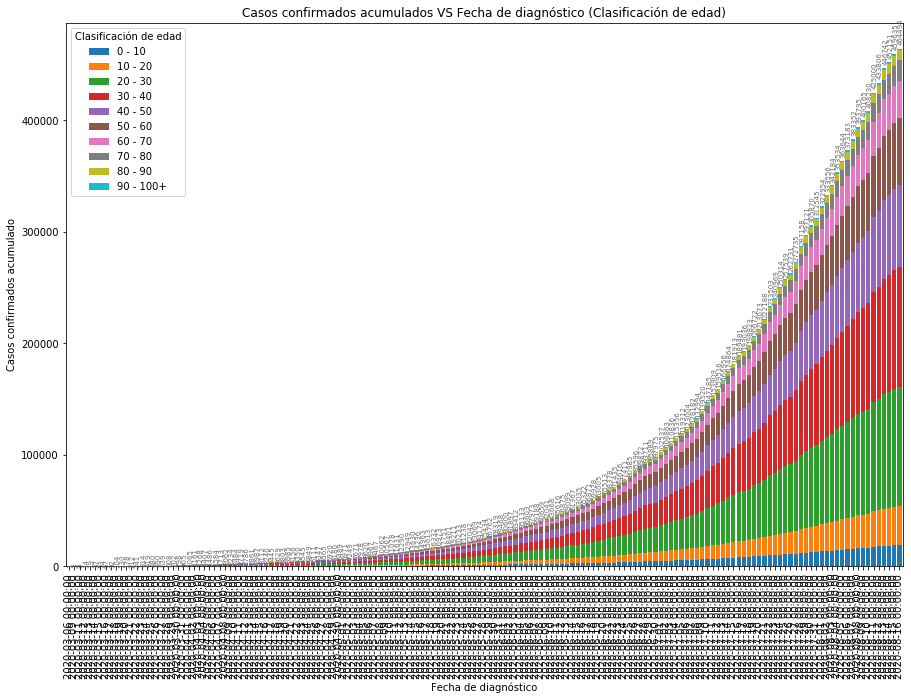

In [34]:
ax = data.groupby(['Fecha de diagnóstico', 'Clasificación de edad']).size().unstack().fillna(0).cumsum().plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados acumulados VS Fecha de diagnóstico (Clasificación de edad)'))
ax.set_ylabel('Casos confirmados acumulado')
div = len(data['Clasificación de edad'].unique())
numbers(div)

In [35]:
data.groupby(['Fecha de diagnóstico', 'Clasificación de edad']).size().unstack().fillna(0).cumsum().tail(60)

Clasificación de edad  0 - 10  10 - 20  20 - 30  30 - 40  40 - 50  50 - 60  \
Fecha de diagnóstico                                                         
2020-06-18               2859     5466    13675    13055     9073     7439   
2020-06-19               3018     5679    14350    13753     9547     7833   
2020-06-20               3133     5827    14946    14346     9934     8165   
2020-06-21               3241     6073    15652    14974    10354     8496   
2020-06-22               3387     6300    16429    15679    10797     8884   
2020-06-23               3539     6553    17159    16385    11289     9291   
2020-06-24               3664     6759    17736    17019    11747     9684   
2020-06-25               3817     7030    18531    17828    12289    10150   
2020-06-26               4035     7362    19580    18946    12984    10713   
2020-06-27               4224     7683    20569    19910    13648    11275   
2020-06-28               4364     7908    21435    20883    14281    11761   
2020-06-29               4462     8081    21974    21386    14627    12012   
2020-06-30               4557     8253    22488    21884    14945    12260   
2020-07-01               4760     8564    23572    22906    15654    12852   
2020-07-02               4926     8883    24570    23878    16343    13423   
2020-07-03               5106     9160    25520    24777    16961    13926   
2020-07-04               5261     9473    26654    25914    17620    14447   
2020-07-05               5413     9746    27548    26820    18232    14996   
2020-07-06               5592    10031    28357    27701    18806    15479   
2020-07-07               5792    10328    29583    28963    19694    16122   
2020-07-08               5981    10654    30675    30105    20464    16746   
2020-07-09               6201    11081    32228    31672    21504    17558   
2020-07-10               6483    11630    34077    33556    22664    18545   
2020-07-11               6732    12075    35695    35172    23744    19401   
2020-07-12               6972    12500    37004    36442    24658    20142   
2020-07-13               7227    12989    38784    38156    25871    21129   
2020-07-14               7523    13571    40657    40034    27147    22104   
2020-07-15               7815    14102    42254    41638    28275    23034   
2020-07-16               8158    14606    43950    43433    29514    24047   
2020-07-17               8281    14824    44749    44292    30059    24498   
2020-07-18               8501    15165    46042    45701    31013    25249   
2020-07-19               8814    15824    47871    47552    32322    26229   
2020-07-20               9091    16281    49221    49008    33387    27056   
2020-07-21               9450    16904    51371    51175    34858    28200   
2020-07-22               9853    17738    54069    53745    36628    29732   
2020-07-23              10128    18248    55731    55474    37817    30711   
2020-07-24              10448    18962    57916    57742    39276    31924   
2020-07-25              10730    19443    59544    59434    40433    32901   
2020-07-26              10940    19766    60728    60653    41237    33578   
2020-07-27              11321    20476    63085    63005    42882    34764   
2020-07-28              11940    21596    66377    66262    45176    36672   
2020-07-29              12309    22317    68754    68681    46822    37878   
2020-07-30              12645    23015    70893    70764    48103    39011   
2020-07-31              12916    23460    72392    72353    49243    39824   
2020-08-01              13319    24303    74912    74832    50841    41138   
2020-08-02              13757    25017    77307    77207    52632    42626   
2020-08-03              14074    25614    79264    79212    53948    43816   
2020-08-04              14553    26414    81879    81853    55808    45374   
2020-08-05              14973    27122    84203    84180    57441    46706   
2020-08-06            

### - Casos confirmados VS Fecha de diagnóstico (Clasificación de edad)

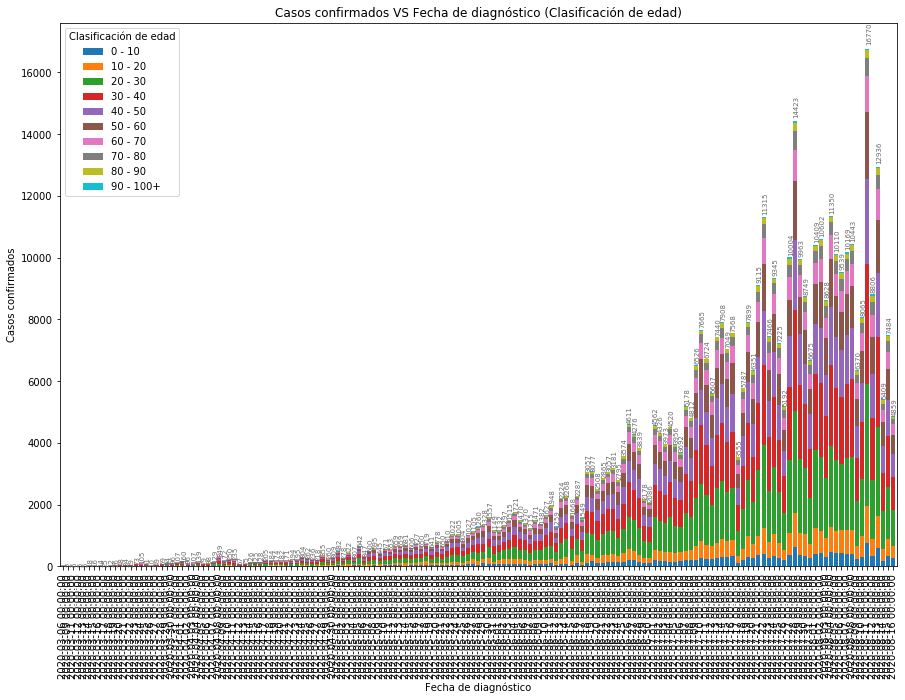

In [36]:
ax = data.groupby(['Fecha de diagnóstico', 'Clasificación de edad']).size().unstack().fillna(0).plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados VS Fecha de diagnóstico (Clasificación de edad)'))
ax.set_ylabel('Casos confirmados')
div = len(data['Clasificación de edad'].unique())
numbers(div)

In [37]:
data.groupby(['Fecha de diagnóstico', 'Clasificación de edad']).size().unstack().fillna(0).tail(60)

Clasificación de edad  0 - 10  10 - 20  20 - 30  30 - 40  40 - 50  50 - 60  \
Fecha de diagnóstico                                                         
2020-06-18                114      278      671      729      456      377   
2020-06-19                159      213      675      698      474      394   
2020-06-20                115      148      596      593      387      332   
2020-06-21                108      246      706      628      420      331   
2020-06-22                146      227      777      705      443      388   
2020-06-23                152      253      730      706      492      407   
2020-06-24                125      206      577      634      458      393   
2020-06-25                153      271      795      809      542      466   
2020-06-26                218      332     1049     1118      695      563   
2020-06-27                189      321      989      964      664      562   
2020-06-28                140      225      866      973      633      486   
2020-06-29                 98      173      539      503      346      251   
2020-06-30                 95      172      514      498      318      248   
2020-07-01                203      311     1084     1022      709      592   
2020-07-02                166      319      998      972      689      571   
2020-07-03                180      277      950      899      618      503   
2020-07-04                155      313     1134     1137      659      521   
2020-07-05                152      273      894      906      612      549   
2020-07-06                179      285      809      881      574      483   
2020-07-07                200      297     1226     1262      888      643   
2020-07-08                189      326     1092     1142      770      624   
2020-07-09                220      427     1553     1567     1040      812   
2020-07-10                282      549     1849     1884     1160      987   
2020-07-11                249      445     1618     1616     1080      856   
2020-07-12                240      425     1309     1270      914      741   
2020-07-13                255      489     1780     1714     1213      987   
2020-07-14                296      582     1873     1878     1276      975   
2020-07-15                292      531     1597     1604     1128      930   
2020-07-16                343      504     1696     1795     1239     1013   
2020-07-17                123      218      799      859      545      451   
2020-07-18                220      341     1293     1409      954      751   
2020-07-19                313      659     1829     1851     1309      980   
2020-07-20                277      457     1350     1456     1065      827   
2020-07-21                359      623     2150     2167     1471     1144   
2020-07-22                403      834     2698     2570     1770     1532   
2020-07-23                275      510     1662     1729     1189      979   
2020-07-24                320      714     2185     2268     1459     1213   
2020-07-25                282      481     1628     1692     1157      977   
2020-07-26                210      323     1184     1219      804      677   
2020-07-27                381      710     2357     2352     1645     1186   
2020-07-28                619     1120     3292     3257     2294     1908   
2020-07-29                369      721     2377     2419     1646     1206   
2020-07-30                336      698     2139     2083     1281     1133   
2020-07-31                271      445     1499     1589     1140      813   
2020-08-01                403      843     2520     2479     1598     1314   
2020-08-02                438      714     2395     2375     1791     1488   
2020-08-03                317      597     1957     2005     1316     1190   
2020-08-04                479      800     2615     2641     1860     1558   
2020-08-05                420      708     2324     2327     1633     1332   
2020-08-06            

### - Casos confirmados VS Estado (Clasificación de edad)

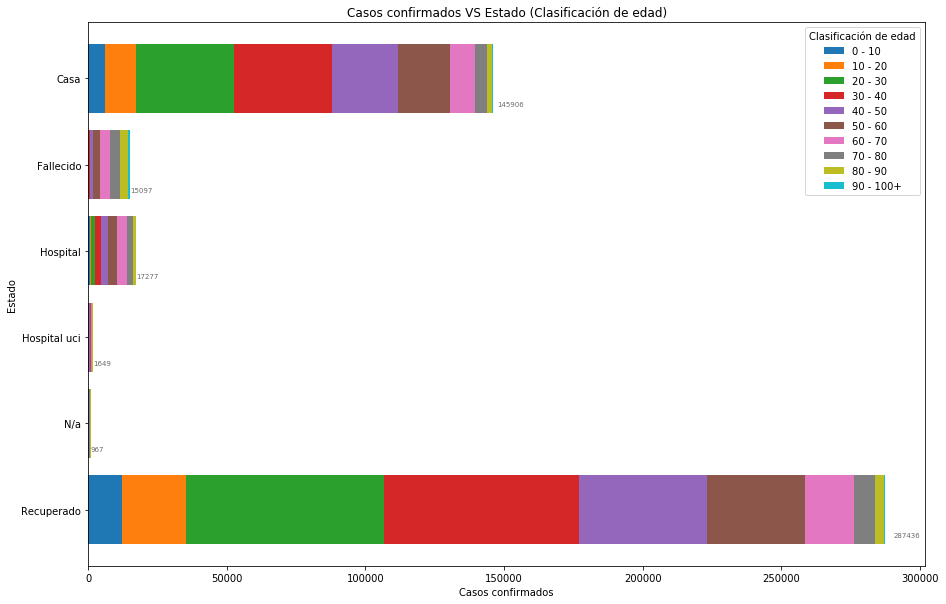

In [38]:
ax = data.groupby(['Estado', 'Clasificación de edad']).size().unstack().fillna(0).sort_index(ascending=False).plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados VS Estado (Clasificación de edad)'))
ax.set_xlabel('Casos confirmados')
div = len(data['Clasificación de edad'].unique())
numbers_H(div)

In [39]:
data.groupby(['Estado', 'Clasificación de edad']).size().unstack().fillna(0)

Clasificación de edad  0 - 10  10 - 20  20 - 30  30 - 40  40 - 50  50 - 60  \
Estado                                                                       
Casa                     6254    11200    35235    35263    23833    18743   
Fallecido                  28       24      200      502     1146     2274   
Hospital                  725      373     1385     2057     2539     3529   
Hospital uci               57       25       69      150      239      415   
N/a                        26       18       42       36       74      118   
Recuperado              12287    23196    71131    70256    46240    35373   

Clasificación de edad  60 - 70  70 - 80  80 - 90  90 - 100+  
Estado                                                       
Casa                      9095     4258     1726        299  
Fallecido                 3659     3825     2800        639  
Hospital                  3258     2215     1043        153  
Hospital uci               377      245       66          6  
N/a                        199      221      186         47  
Recuperado               17636     7781     3046        490

### - Casos confirmados VS Tipo de contagio (Clasificación de edad)

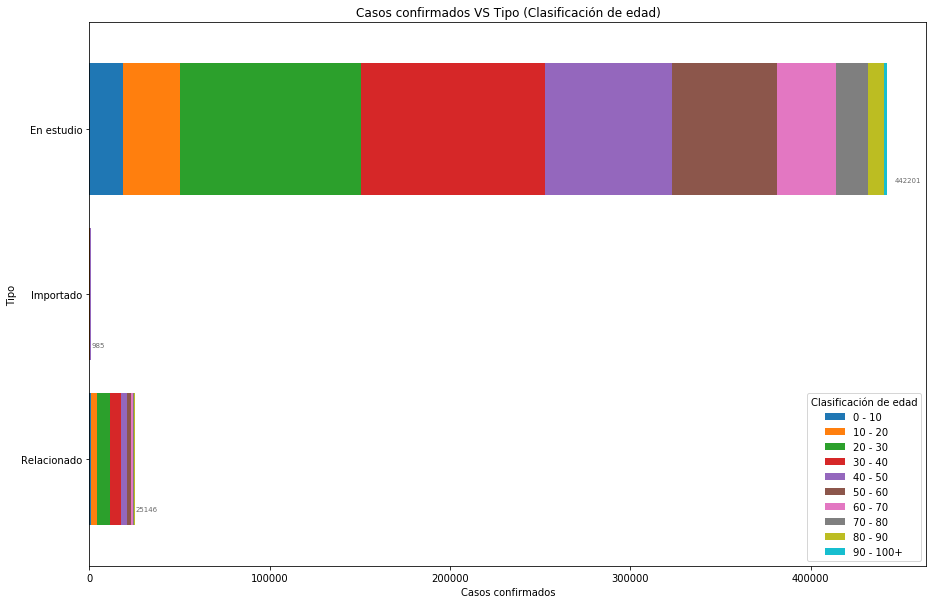

In [40]:
ax = data.groupby(['Tipo', 'Clasificación de edad']).size().unstack().fillna(0).sort_index(ascending=False).plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=('Casos confirmados VS Tipo (Clasificación de edad)'))
ax.set_xlabel('Casos confirmados')
div = len(data['Clasificación de edad'].unique())
numbers_H(div)

In [41]:
data.groupby(['Tipo', 'Clasificación de edad']).size().unstack().fillna(0)

Clasificación de edad  0 - 10  10 - 20  20 - 30  30 - 40  40 - 50  50 - 60  \
Tipo                                                                         
En estudio              18419    31729   100614   101713    70632    58040   
Importado                   5       38      246      231      173      152   
Relacionado               953     3069     7202     6320     3266     2260   

Clasificación de edad  60 - 70  70 - 80  80 - 90  90 - 100+  
Tipo                                                         
En estudio               32977    17986     8539       1552  
Importado                   95       35        9          1  
Relacionado               1152      524      319         81

### Made with ♥ by <a href='https://github.com/jlcadavid'>@jlcadavid</a>

## #StayHome #QuédateEnCasa - #WearMask #UsaTapabocas